In [1]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from datetime import datetime

repo_dir = os.getcwd() + '/repo'
tft_dir = os.path.join(repo_dir, 'tft')
os.chdir(tft_dir)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
!ls

 carriage_services.csv		     'outputs_mobiact(v2)_swa'
 data_formatters		     'outputs_mobiact(v2)_swa2'
 data_formatters.zip		     'outputs_mobiact(v2)(undersampling)'
 dlr_preprocessed		     'outputs_mobiact(v2)_wo_pinfo'
 dlr_tft_results		      outputs_mobiact_wo_age
 ETTm1.csv			      outputs_mobiact_wo_gender
 ETTm2.csv			      outputs_mobiact_wo_known
 expt_settings			      outputs_mobiact_wo_known_no_bioinfo
 expt_settings.zip		      outputs_mobiact_wo_known_no_bioinfo2
 libs				      outputs_notchFall
 libs.zip			     'outputs_notchFall(oversampling)'
 mobiact_dataset		      outputs_notchFall_swa
 MobiAct_Dataset_v2.0.rar	     'outputs_notchFall(undersampling)'
 MobiAct_Dataset_v2-Copy1.0.rar       outputs_pm2.5
 mobiact_preprocessed		      outputs_smartFall
 MobiAct_preprocessed.zip	     'outputs_smartFall(oversampling)'
 mobi_tft_wo_known_no_bioinfo	      outputs_smartFall_swa
 mobi_tft_wo_known_results	     'outputs_smartFall(undersampling)'
 notch_dataset			      outputs_st

In [3]:
output_folder = os.path.join(os.getcwd(), 'outputs_mobiact_wo_known')   # Root folder to save experiment outputs
force_download = False 
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [4]:
file = open('mobiact_dataset/Readme.txt', 'r', encoding='latin1')
strings = file.readlines()
file.close()
for s in strings:
    print(s)


===========================MobiActDataset===========================

The NEW version of the MobiAct dataset includes:

 	Four different types of falls performed by 66 participants

 	Eleven different types of ADLs performed by 19 participants and nine types of ADLs performed by 59 participants (plus one activity "LYI" which results from the inactivity period after a fall by 66 participants)

 	Five sub-scenarios which construct one scenario of daily living, which consists of a sequence of 50 activities and performed by 19 participants.



The new released version of the MobiAct dataset includes:

  The raw recorded data in txt format, separated by each activity

  The annotated data in csv format, separated by each activity





Filename format:

<ADL OR FALL OR SCENARIO_CODE>_<SENSOR_CODE>_<SUBJECT_ID>_<TRIAL_NO>.txt



examples:

1 -->	WAL_acc_5_1.txt

2 -->	STD_ori_9_5.txt

3 -->	FKL_gyro_3_2.txt

4 -->	SRH_acc_1_1.txt





Subjects:

+------+---------+-----------+-------+---

In [5]:
person_list = []
for s in strings:
    if 'sub' in s and '|' in s:
        temp = s.split('|')
        temp = [x.strip() for x in temp]
        if len(temp) == 9:
            person_list.append(temp[3:-1])

activity_list = []
for s in strings:
    if '|' in s:
        temp = s.split('|')
        temp = [x.strip() for x in temp]
        if len(temp) == 8:
            activity_list.append(temp[1:-1])

In [6]:
falls = ['FOL', 'FKL', 'BSC', 'SDL']

columns = ['name', 'age', 'height', 'weight', 'gender']
person_info = pd.DataFrame(person_list, columns=columns)

activity_info = pd.DataFrame(activity_list)
activity_info.columns = activity_info.iloc[0]
activity_info = activity_info.drop(0)
activity_info = activity_info.drop(13)
activity_info = activity_info.reset_index(drop=True)
# print(activity_info.columns)
index = activity_info['No.']
activity_info = activity_info.drop(['No.'], axis=1)
activity_info.index = index
activity_info['label_encoded'] = list(range(len(activity_info)))

# Data preprocessing

In [7]:
data_dir = 'mobiact_dataset/'
file_list = os.listdir(data_dir)
file_list = [file for file in file_list if file.endswith('.csv')]
file_list[:3]

['FKL_20_3_annotated.csv', 'FKL_17_3_annotated.csv', 'SCH_22_6_annotated.csv']

In [8]:
train = pd.read_csv('mobiact_preprocessed/train.csv', index_col=0)
valid = pd.read_csv('mobiact_preprocessed/valid.csv', index_col=0)
test = pd.read_csv('mobiact_preprocessed/test.csv', index_col=0)

In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(activity_info['Label'])

train_encoded = encoder.transform(train['label'])
train['label_encoded'] = train_encoded

valid_encoded = encoder.transform(valid['label'])
valid['label_encoded'] = valid_encoded

test_encoded = encoder.transform(test['label'])
test['label_encoded'] = test_encoded

In [10]:
train['known'] = 0
valid['known'] = 0
test['known'] = 0

train['circum'] = 0
valid['circum'] = 0
test['circum'] = 0

In [11]:
train.head()

,timestamp,rel_time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,...,label,person_id,person_age,person_height,person_weight,person_gender,trial_num,label_encoded,known,circum
0,4122885402000,0.000000,3.238091,8.132329,4.245767,0.049480,-0.007636,-0.013744,273.73670,-67.593300,...,SIT,6,22,172,62,F,4,11,0,0
1,4122890370000,0.004968,3.256741,8.139323,4.259755,0.045204,-0.008552,-0.003360,274.05545,-67.167404,...,SIT,6,22,172,62,F,4,11,0,0
2,4122895406000,0.010004,3.275647,8.146413,4.273935,0.040012,-0.004887,-0.009163,274.36743,-66.759420,...,SIT,6,22,172,62,F,4,11,0,0
3,4122900447000,0.015045,3.294929,8.154904,4.283354,0.032681,-0.011301,-0.018631,274.72174,-66.325455,...,SIT,6,22,172,62,F,4,11,0,0
4,4122905384000,0.019982,3.314145,8.164513,4.288158,0.029322,-0.002443,-0.014966,275.06073,-65.903100,...,SIT,6,22,172,62,F,4,11,0,0


# Data Formatter

In [12]:
from data_formatters.base import GenericDataFormatter, DataTypes, InputTypes

# View avialable inputs and data types.
print("Available data types:")
for option in DataTypes:
    print(option)

print()
print("Avaialbe input types:")
for option in InputTypes:
    print(option)

Available data types:
DataTypes.REAL_VALUED
DataTypes.CATEGORICAL
DataTypes.DATE

Avaialbe input types:
InputTypes.TARGET
InputTypes.OBSERVED_INPUT
InputTypes.KNOWN_INPUT
InputTypes.STATIC_INPUT
InputTypes.ID
InputTypes.TIME


In [22]:
from libs import utils 
import sklearn.preprocessing
class MobiActFormatter(GenericDataFormatter):
    _column_definition = [
        ('person_id', DataTypes.CATEGORICAL, InputTypes.ID),
        ('rel_time', DataTypes.REAL_VALUED, InputTypes.TIME),
        ('known', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
#         ('circum', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('acc_x', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('acc_y', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('acc_z', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('gyro_x', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('gyro_y', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('gyro_z', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('label_encoded', DataTypes.REAL_VALUED, InputTypes.TARGET),
        ('person_gender', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('person_height', DataTypes.REAL_VALUED, InputTypes.STATIC_INPUT),
        ('person_weight', DataTypes.REAL_VALUED, InputTypes.STATIC_INPUT),
        ('person_age', DataTypes.REAL_VALUED, InputTypes.STATIC_INPUT)
    ]
    
    def __init__(self):
        """initializes formatter"""
        
        self.identifiers = None
        self._real_scalers = None
        self._cat_scalers = None
        self._target_scaler = None
        self._num_classes_per_cat_input = None
    
    def split_data(self, train, valid, test):
        """
        split data frame into training-validation-test data frames
        
        """
        print('Formatting train-valid-test splits.')
        
        train_data = train

        val_data = valid
        
        test_data = test
        
        self.set_scalers(train_data)
        
        return (self.transform_inputs(data) for data in [train_data, val_data, test_data])
    
    def set_scalers(self, df):
        """
        Calibrates scalers using the data supplied.
        (제공된 데이터를 사용해서 scaler 교정)

        Args:
          df: Data to use to calibrate scalers.
        """
        print('Setting scalers with training data...')
        
        column_definitions = self.get_column_definition()

        id_column = utils.get_single_col_by_input_type(InputTypes.ID,
                                                       column_definitions)
        target_column = utils.get_single_col_by_input_type(InputTypes.TARGET,
                                                           column_definitions)
        # extract identifiers in case required
        self.identifiers = list(df[id_column].unique())
        
        # Format real scalers
        real_inputs = utils.extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        
        data = df[real_inputs].values
        self._real_scalers = sklearn.preprocessing.StandardScaler().fit(data)
        
        # target데이터를 prediction에 사용
        self._target_scaler = sklearn.preprocessing.StandardScaler().fit(df[[target_column]].values)
        
        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        
        categorical_scalers = {}
        num_classes = []
        for col in categorical_inputs:
            srs = df[col].apply(str)
            categorical_scalers[col] = sklearn.preprocessing.LabelEncoder().fit(srs.values)
            num_classes.append(srs.nunique())
        
        # set categorical scaler outputs
        self._cat_scalers = categorical_scalers
        self._num_classes_per_cat_input = num_classes
        
    def transform_inputs(self, df):
        """
        performs feature transformations.
        
        feature engineering, preprocessing and normalization을 포함
        
        Args:
            df - data frame to transform.
            
        Returns:
            Transformed data frame.
        """
        output = df.copy()
        
        if self._real_scalers is None and self._cat_scalers is None:
            raise ValueError('Scalers have not been set!')
        
        column_definitions = self.get_column_definition()
        real_inputs = utils.extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME}
        )
        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        output[real_inputs] = self._real_scalers.transform(df[real_inputs].values)
        for col in categorical_inputs:
            string_df = df[col].apply(str)
            output[col] = self._cat_scalers[col].transform(string_df)
        return output
    
    def format_predictions(self, predictions):
        output = predictions.copy()
        
        column_names = predictions.columns
        for col in column_names:
            if col not in {'forecast_time', 'identifier'}:
                output[col] = self._target_scaler.inverse_transform(predictions[col])
                
        return output
    
    def get_fixed_params(self):
        fixed_params = {
            'total_time_steps': 87,     # Total width of the Temporal Fusion Decoder
            'num_encoder_steps': 43,    # Length of LSTM decoder (ie. # historical inputs)
            'num_epochs': 100,            # Max number of epochs for training
            'early_stopping_patience': 5, # Early stopping threshold for # iterations with no loss improvement
            'multiprocessing_workers': 5  # Number of multi-processing workers
        }
        
        return fixed_params
    
    def get_default_model_params(self):
        model_params = {
            'dropout_rate': 0.3,
            'hidden_layer_size': 160,
            'learning_rate': 0.01,
            'minibatch_size': 64,
            'max_gradient_norm': 0.01,
            'num_heads': 4,
            'stack_size': 1
        }

        return model_params

In [23]:
data_formatter = MobiActFormatter()
train, valid, test = data_formatter.split_data(train, valid, test)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )

Formatting train-valid-test splits.
Setting scalers with training data...


# Model

In [24]:
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as util

ModelClass = libs.tft_model.TemporalFusionTransformer
data_params = data_formatter.get_experiment_params()
param_ranges = ModelClass.get_hyperparm_choices()

In [25]:
model_params = {'dropout_rate': 0.3,      # Dropout discard rate
                'hidden_layer_size': 320, # Internal state size of TFT
                'learning_rate': 0.001,   # ADAM initial learning rate
                'minibatch_size': 512,    # Minibatch size for training
                'max_gradient_norm': 100.,# Max norm for gradient clipping
                'num_heads': 4,           # Number of heads for multi-head attention
                'stack_size': 1           # Number of stacks (default 1 for interpretability)
               }

In [26]:
model_folder = os.path.join(output_folder, 'saved_models', 'MobiAct_wo_known', 'fixed')
model_params['model_folder'] = model_folder

model_params.update(data_params)

In [27]:
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
print("*** Loading hyperparm manager ***")
opt_manager = HyperparamOptManager(param_ranges, data_params, model_folder)

*** Loading hyperparm manager ***


In [28]:
success = opt_manager.load_results()
restart_opt = None
if success and not restart_opt:
    print("Loaded results from previous training")
else:
    print("Creating new hyperparameter optimisation")
    opt_manager.clear()

Loading results from /workspace/inkyung/TFT/repo/tft/outputs_mobiact_wo_known/saved_models/MobiAct_wo_known/fixed
Loaded results from previous training


In [29]:
import tensorflow as tf
from libs.tft_model import TemporalFusionTransformer

# Specify GPU usage
tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id='3')

Selecting GPU ID=3


# Training

In [ ]:
tf.compat.v1.get_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:
    tf.compat.v1.keras.backend.set_session(sess)
    params = opt_manager.get_next_parameters()
    # Create a TFT model
    model = TemporalFusionTransformer(model_params,
                                    use_cudnn=True) # Run model on GPU using CuDNNLSTM cells
    
    # Sample data into minibatches for training
    if not model.training_data_cached():
        model.cache_batched_data(train, "train", num_samples=train_samples)
        model.cache_batched_data(valid, "valid", num_samples=valid_samples)

    # Train and save model
    model.fit()
    
    val_loss = model.evaluate()
    if np.allclose(val_loss, 0.) or np.isnan(val_loss):
        # Set all invalid losses to infintiy.
        # N.b. val_loss only becomes 0. when the weights are nan.
        print("Skipping bad configuration....")
        val_loss = np.inf
    opt_manager.update_score(params, val_loss, model)
    tf.compat.v1.keras.backend.set_session(sess)
    model.save(model_folder)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.001
# minibatch_size = 512
# max_gradient_norm = 100.0
# num_heads = 4
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_mobiact_wo_known/saved_models/MobiAct_wo_known2/fixed
# total_time_steps = 87
# num_encoder_steps = 43
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('person_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('rel_time', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('acc_x', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('acc_y', <Data

Cached data "train" updated
Cached data "valid" updated
*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 11188446 samples, validate on 834023 samples
Epoch 1/100
11188446/11188446 [==============================] - 14259s 1ms/sample - loss: 0.0409 - val_loss: 0.0276
Epoch 2/100
11188446/11188446 [==============================] - 15847s 1ms/sample - loss: 0.0301 - val_loss: 0.0255
Epoch 3/100
11188446/11188446 [==============================] - 12447s 1ms/sample - loss: 0.0262 - val_loss: 0.0252
Epoch 4/100
11188446/11188446 [==============================] - 12308s 1ms/sample - loss: 0.0267 - val_loss: 0.0239
Epoch 5/100
11188446/11188446 [==============================] - 12304s 1ms/sample - loss: 0.0253 - val_loss: 0.0240
Epoch 6/100
11188446/11188446 [==============================] - 12305s 1ms/sample - loss: 0.0260 - val_loss: 0.0246
Epoch 7/100
 2179072/11188446 [====>........

# Evalution 

In [30]:
tf.compat.v1.reset_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:
    tf.compat.v1.keras.backend.set_session(sess)
    # Create a new model & load weights
    model = TemporalFusionTransformer(model_params,
                                      use_cudnn=True)
    model.load(model_folder)
    
    # Make forecasts
    output_map = model.predict(test, return_targets=True)
    
    targets = data_formatter.format_predictions(output_map["targets"])
    # Format predictions
    
    p50_forecast = data_formatter.format_predictions(output_map["p50"])
    p90_forecast = data_formatter.format_predictions(output_map["p90"])

    def extract_numerical_data(data):
        """Strips out forecast time and identifier columns."""
        return data[[
            col for col in data.columns
            if col not in {"forecast_time", "identifier"}
        ]]
    # Compute Losses
    p50_loss = utils.numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p50_forecast),
        0.5)
    p90_loss = utils.numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p90_forecast),
        0.9)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.001
# minibatch_size = 512
# max_gradient_norm = 100.0
# num_heads = 4
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_mobiact_wo_known/saved_models/MobiAct_wo_known/fixed
# total_time_steps = 87
# num_encoder_steps = 43
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('person_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('rel_time', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('known', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('acc_x', <DataType

Loading model from /workspace/inkyung/TFT/repo/tft/outputs_mobiact_wo_known/saved_models/MobiAct_wo_known/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/dense/bias (float32) [320]
[ 2.54986398e-02  1.08277187e-01 -8.07878152e-02 -1.85402203e-02
  1.10578127e-01  1.07195802e-01 -1.39216930e-01  1.40531687e-02
  3.04258037e-02 -5.17606642e-03  1.12635963e-01  2.96761375e-03
  2.85044238e-02 -1.02989167e-01  1.61318798e-02  1.09409178e-02
 -1.03754252e-01  6.65813312e-03 -1.74571630e-02  3.02712340e-02
 -2.09073815e-02 -8.08294043e-02 -1.24465814e-02 -9.09352209e-03
 -8.60693678e-03  1.12005778e-01  1.12413457e-02  8.24606686e-04
 -1.38916597e-02 -9.86697152e-03 -1.09430440e-01  2.82135420e-03
 -8.97742994e-03 -6.48090572e-05  1.69753879e-02 -2.17382261e-03
  1.11342356e-01 -4.73993197e-02  1.16927773e-02  1.11136353e-02
  9.39951688e-02  1.00272186e-01 -1.20255686e-01  7.73512945e-02
  1.20342739e-01  1.23393573e-01 -1.13011770e-01 -5.05958917e-03
  2.38973945e-02

[[ 0.06727668  0.07898979 -0.11345012 ... -0.04014234 -0.12806857
  -0.05115594]
 [ 0.04676714 -0.02197533  0.0868341  ... -0.07347589  0.15700507
  -0.12536703]
 [ 0.055184   -0.08293875 -0.07193356 ...  0.01519166  0.07985898
  -0.05639802]
 ...
 [ 0.05337926 -0.0007158  -0.05418274 ... -0.02108951 -0.00089603
   0.00320002]
 [-0.06760542 -0.03338118 -0.10664918 ...  0.00190566  0.07320289
   0.02466271]
 [ 0.03418974 -0.01069968  0.06973218 ... -0.07977357  0.07698188
   0.06489744]]
tensor: TemporalFusionTransformer/dense_45/bias (float32) [320]
[ 1.74707085e-01 -1.13071002e-01  3.74819594e-03  6.50231764e-02
  7.63203949e-02 -5.46813058e-03  1.82425678e-01  6.28550351e-02
 -3.56303900e-02 -6.22371510e-02 -3.98091078e-02 -1.24743983e-01
  1.33336142e-01 -1.18076429e-02  1.60816927e-02  8.00995063e-03
 -1.32083610e-01 -1.08766645e-01  4.77319062e-02 -2.80124620e-02
 -5.35656326e-03 -3.93775031e-02  1.85237005e-02 -4.88471985e-03
  5.01700826e-02  8.65794718e-02 -9.53467190e-02  2.62

[[ 0.1353991  -0.28795674  0.15040636 ...  0.28039077 -0.00513107
  -0.1261286 ]
 [-0.19048618  0.05700412 -0.1974768  ...  0.10470347 -0.19180886
   0.05953256]
 [-0.18559285 -0.11115247  0.12694386 ... -0.08198312 -0.00790026
   0.1178076 ]
 ...
 [ 0.12161011 -0.13763985  0.10721651 ...  0.21727118 -0.02923354
  -0.11539769]
 [ 0.12557222 -0.02514277  0.16057053 ...  0.28148237  0.18810233
  -0.11161058]
 [-0.206241    0.32153156 -0.1431944  ...  0.07792483  0.18066998
  -0.39749908]]
tensor: TemporalFusionTransformer/lstm/lstm_cell/recurrent_kernel (float32) [320, 1280]
[[-0.11123656 -0.15903787 -0.04323132 ...  0.27038306  0.07460351
   0.14199631]
 [ 0.0523899   0.09896355  0.02865885 ...  0.02956877 -0.06580266
  -0.06171256]
 [-0.15729573  0.06512324  0.26790157 ...  0.00380047 -0.27448893
   0.07126869]
 ...
 [ 0.0219446   0.06132308 -0.12093031 ...  0.36787504 -0.17250265
  -0.32866007]
 [ 0.17379332  0.13313772  0.12330166 ... -0.07702562  0.27501288
   0.07185534]
 [-0.06461

[[-1.09483816e-01]
 [ 1.89130902e-02]
 [-9.30545628e-02]
 [-8.82947147e-02]
 [ 3.41355503e-02]
 [ 2.54318565e-02]
 [-1.21997423e-01]
 [ 5.74302524e-02]
 [ 4.97572422e-02]
 [ 1.95758045e-03]
 [-8.79918933e-02]
 [-3.23562101e-02]
 [-1.19654104e-01]
 [-7.79326707e-02]
 [ 9.42218304e-02]
 [-1.06234431e-01]
 [-3.62064689e-02]
 [-7.97948241e-03]
 [-8.77540410e-02]
 [-1.22635551e-01]
 [ 7.09382296e-02]
 [-1.34663224e-01]
 [ 4.96849120e-02]
 [-1.48391947e-02]
 [-6.63280934e-02]
 [ 4.41686064e-02]
 [ 6.60726130e-02]
 [-9.90455300e-02]
 [-1.46601796e-02]
 [ 1.25287756e-01]
 [-1.33601606e-01]
 [-1.15341432e-01]
 [-4.86395657e-02]
 [-1.18226275e-01]
 [ 4.86153811e-02]
 [-4.32965681e-02]
 [ 8.43566656e-02]
 [-5.30645549e-02]
 [-1.12864763e-01]
 [-1.19399786e-01]
 [ 9.61832553e-02]
 [-3.75597849e-02]
 [-1.65482610e-02]
 [ 5.48004508e-02]
 [ 2.91366428e-02]
 [-6.24082386e-02]
 [-5.84584475e-03]
 [ 9.75231379e-02]
 [ 9.11962986e-02]
 [-8.18698555e-02]
 [-1.07652903e-01]
 [ 1.26008913e-01]
 [-1.2110504

INFO:tensorflow:Restoring parameters from /workspace/inkyung/TFT/repo/tft/outputs_mobiact_wo_known/saved_models/MobiAct_wo_known/fixed/TemporalFusionTransformer.ckpt
Done.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [22]:
import datetime as dte
print("Hyperparam optimisation completed @ {}".format(dte.datetime.now()))
# print("Best validation loss = {}".format(val_loss))
# print("Params:")

# for k in best_params:
#     print(k, " = ", best_params[k])
#     print()
print("Normalised quantile losses: P50={}, P90={}".format(p50_loss.mean(), p90_loss.mean()))

Hyperparam optimisation completed @ 2021-06-23 05:23:56.310502
Normalised quantile losses: P50=0.005589592922218171, P90=0.0049939364902067684


In [45]:
import itertools
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black",
                         fontsize='xx-large')
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black",
                         fontsize='xx-large')

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass), fontsize=30)
    plt.show()

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def getScores(forecast, target):
    predicted, transformed_target = list(), list()

    for i in range(len(forecast)):
        value = forecast.iloc[i].values
        for v in value:
            if v < 16.5 and v >= 15.5:
                predicted.append(16.0)
            elif v < 15.5 and v >= 14.5:
                predicted.append(15.0)
            elif v < 14.5 and v >= 13.5:
                predicted.append(14.0)
            elif v < 13.5 and v >= 12.5:
                predicted.append(13.0)
            elif v < 12.5 and v >= 11.5:
                predicted.append(12.0)
            elif v < 11.5 and v >= 10.5:
                predicted.append(11.0)
            elif v < 10.5 and v >= 9.5:
                predicted.append(10.0)
            elif v < 9.5 and v >= 8.5:
                predicted.append(9.0)
            elif v < 8.5 and v >= 7.5:
                predicted.append(8.0)
            elif v < 7.5 and v >= 6.5:
                predicted.append(7.0)
            elif v < 6.5 and v >= 5.5:
                predicted.append(6.0)
            elif v < 5.5 and v >= 4.5:
                predicted.append(5.0)
            elif v < 4.5 and v >= 3.5:
                predicted.append(4.0)
            elif v < 3.5 and v >= 2.5:
                predicted.append(2.0)
            elif v < 2.5 and v >= 1.5:
                predicted.append(2.0)
            elif v < 1.5 and v >= 0.5:
                predicted.append(0.0)
            elif v < 0.5 and v >= -.5:
                predicted.append(0.0)
                
    for i in range(len(target)):
        value = target.iloc[i].values
        for v in value:
            if v < 16.5 and v >= 15.5:
                transformed_target.append(16.0)
            elif v < 15.5 and v >= 14.5:
                transformed_target.append(15.0)
            elif v < 14.5 and v >= 13.5:
                transformed_target.append(14.0)
            elif v < 13.5 and v >= 12.5:
                transformed_target.append(13.0)
            elif v < 12.5 and v >= 11.5:
                transformed_target.append(12.0)
            elif v < 11.5 and v >= 10.5:
                transformed_target.append(11.0)
            elif v < 10.5 and v >= 9.5:
                transformed_target.append(10.0)
            elif v < 9.5 and v >= 8.5:
                transformed_target.append(9.0)
            elif v < 8.5 and v >= 7.5:
                transformed_target.append(8.0)
            elif v < 7.5 and v >= 6.5:
                transformed_target.append(7.0)
            elif v < 6.5 and v >= 5.5:
                transformed_target.append(6.0)
            elif v < 5.5 and v >= 4.5:
                transformed_target.append(5.0)
            elif v < 4.5 and v >= 3.5:
                transformed_target.append(4.0)
            elif v < 3.5 and v >= 2.5:
                transformed_target.append(2.0)
            elif v < 2.5 and v >= 1.5:
                transformed_target.append(2.0)
            elif v < 1.5 and v >= 0.5:
                transformed_target.append(0.0)
            elif v < 0.5 and v >= -.5:
                transformed_target.append(0.0)
            else:
                print(v)
    
    recall = recall_score(transformed_target, predicted, average='macro')
    precision = precision_score(transformed_target, predicted, average='macro')
    f1 = f1_score(transformed_target, predicted, average='macro')
    acc = accuracy_score(transformed_target, predicted)
    cm = confusion_matrix(transformed_target, predicted)
    plot_confusion_matrix(cm)
    return acc, precision, recall, f1

In [47]:
print(p50_forecast['identifier'].unique())
p50_forecast.head()

[54 55 56 57 58 59 60 61 62 63 64 65 66 67]


,forecast_time,identifier,t+0,t+1,t+2,t+3,t+4,t+5,t+6,t+7,...,t+34,t+35,t+36,t+37,t+38,t+39,t+40,t+41,t+42,t+43
0,0.209990,54,11.997051,11.997215,11.997260,11.997263,11.997259,11.997254,11.997252,11.997248,...,11.997197,11.997196,11.997195,11.997195,11.997193,11.997192,11.997191,11.997191,11.99719,11.99719
1,0.215368,54,11.997051,11.997214,11.997259,11.997263,11.997259,11.997254,11.997252,11.997248,...,11.997197,11.997196,11.997195,11.997195,11.997193,11.997192,11.997192,11.997191,11.99719,11.99719
2,0.220053,54,11.997051,11.997214,11.997260,11.997263,11.997259,11.997254,11.997252,11.997248,...,11.997197,11.997196,11.997195,11.997195,11.997193,11.997192,11.997191,11.997191,11.99719,11.99719
3,0.225053,54,11.997051,11.997214,11.997260,11.997263,11.997259,11.997254,11.997252,11.997248,...,11.997197,11.997196,11.997195,11.997195,11.997193,11.997192,11.997191,11.997191,11.99719,11.99719
4,0.230049,54,11.997051,11.997214,11.997259,11.997263,11.997259,11.997254,11.997252,11.997248,...,11.997197,11.997196,11.997195,11.997195,11.997193,11.997193,11.997191,11.997191,11.99719,11.99719


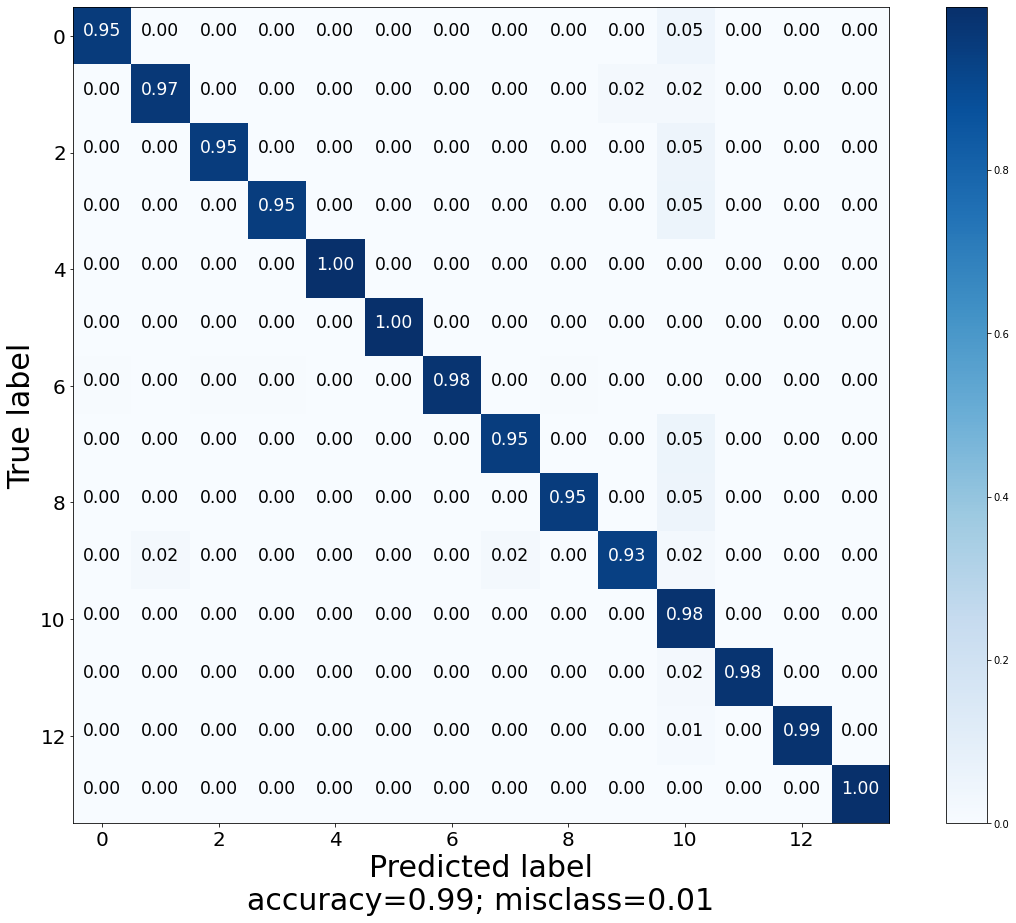

Done  54


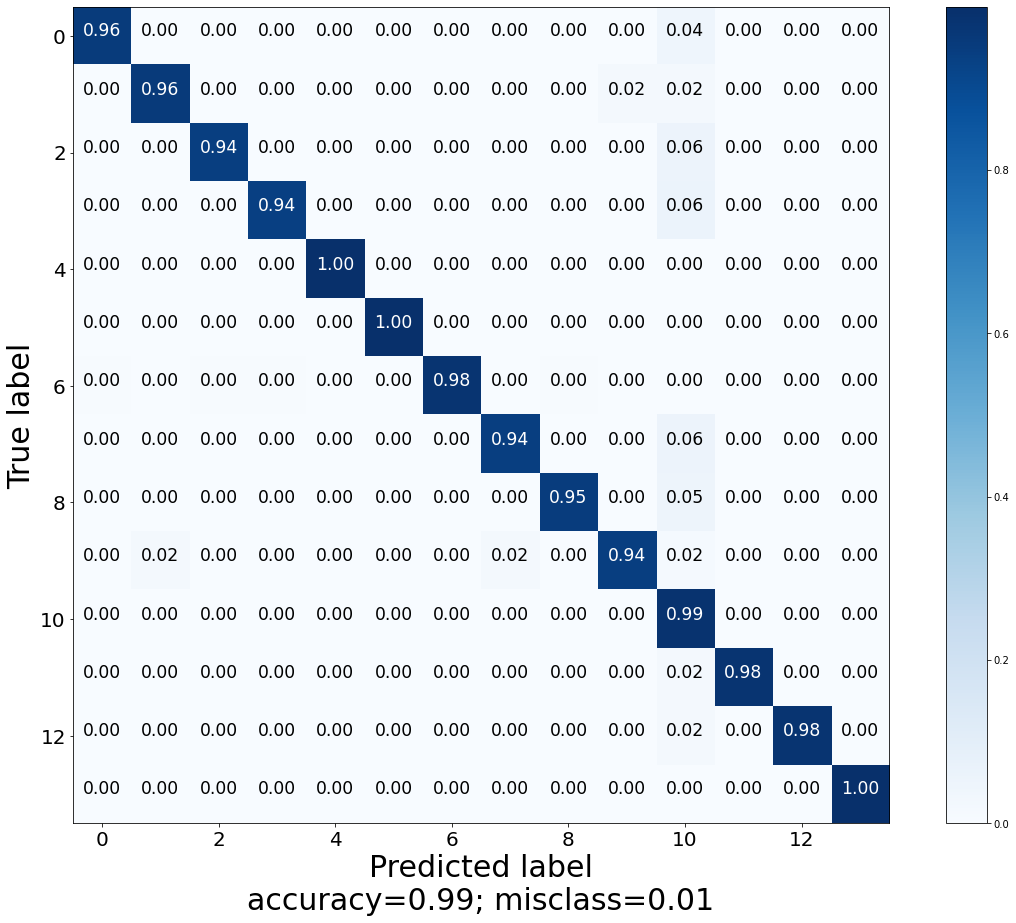

Done  55


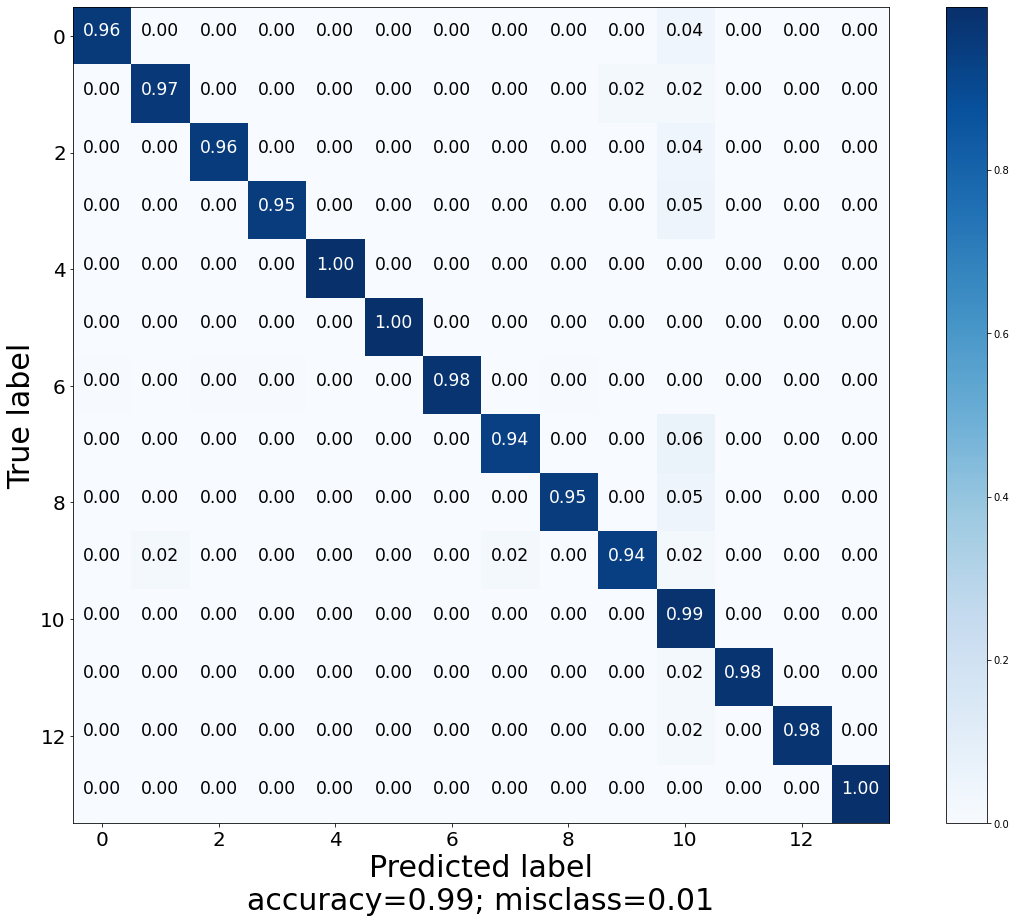

Done  56


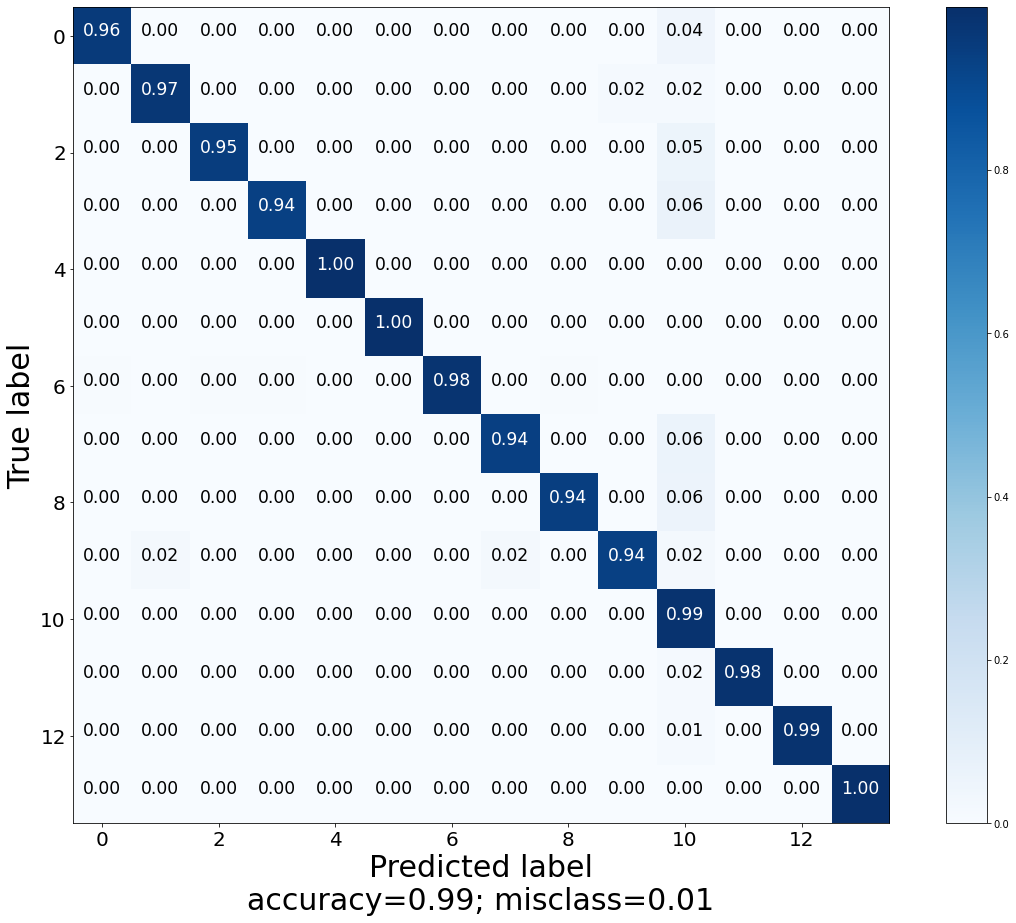

Done  57


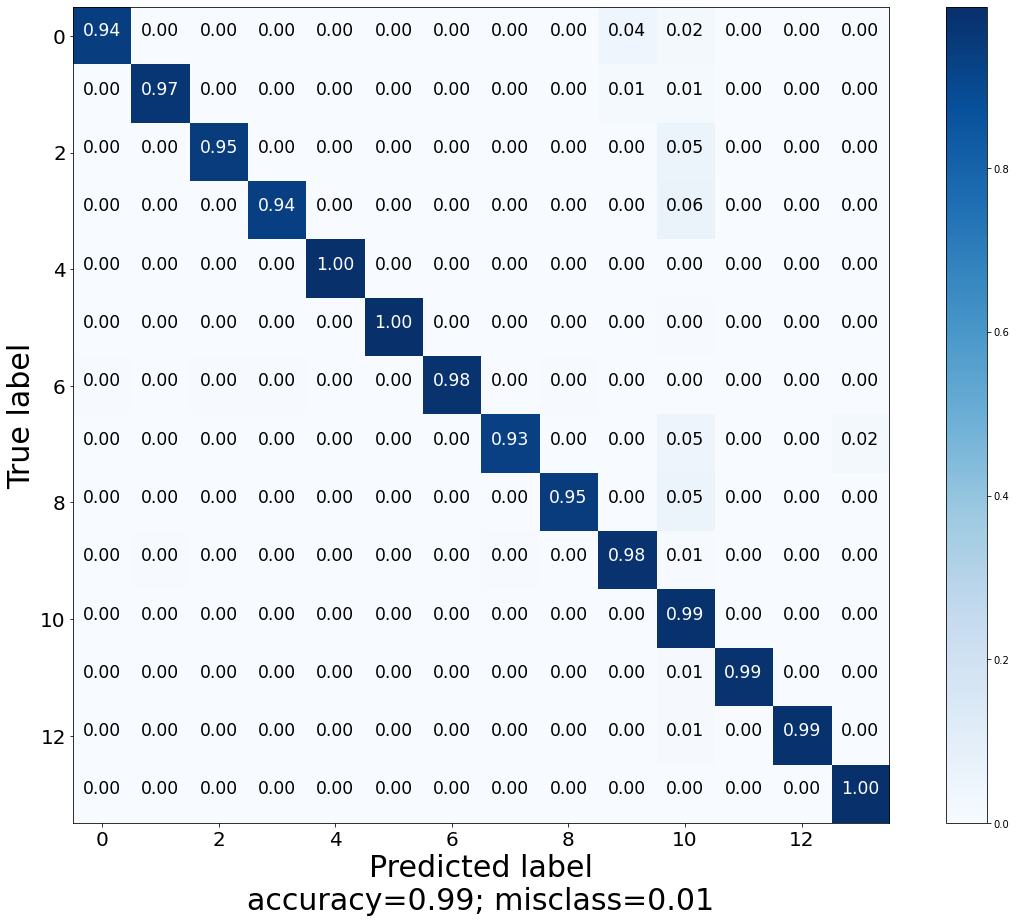

Done  58


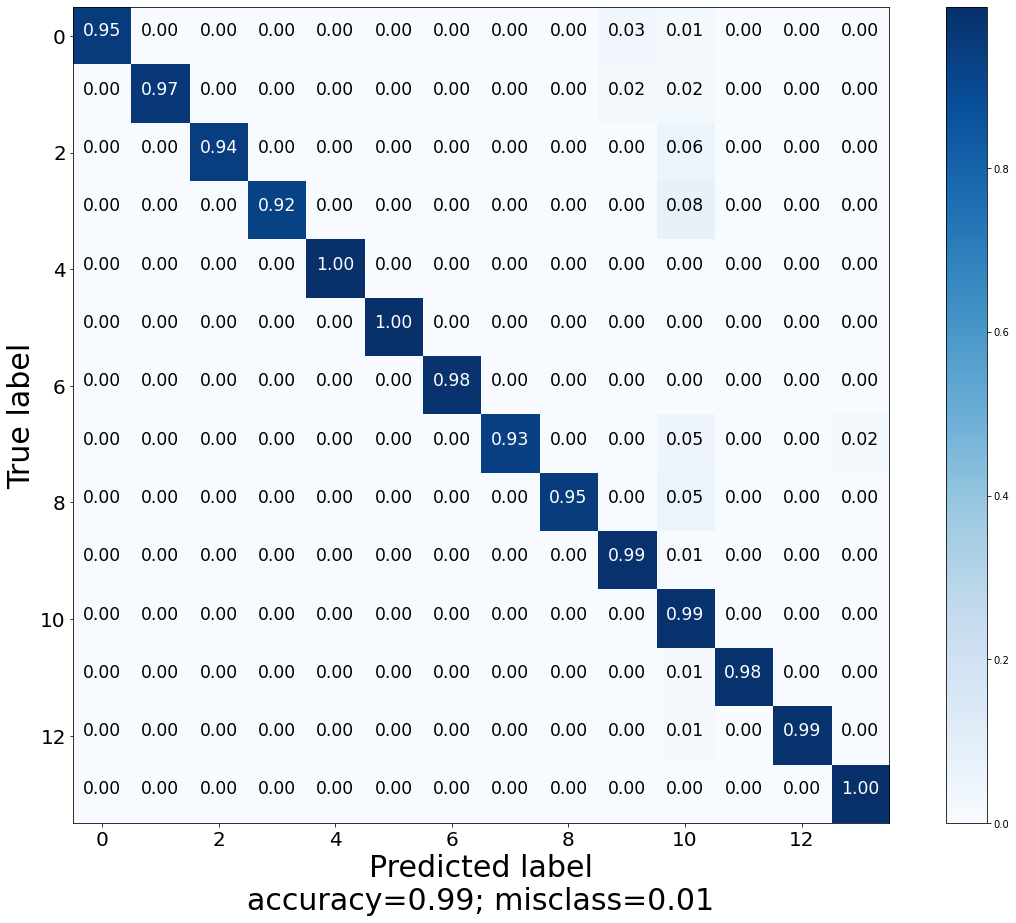

Done  59


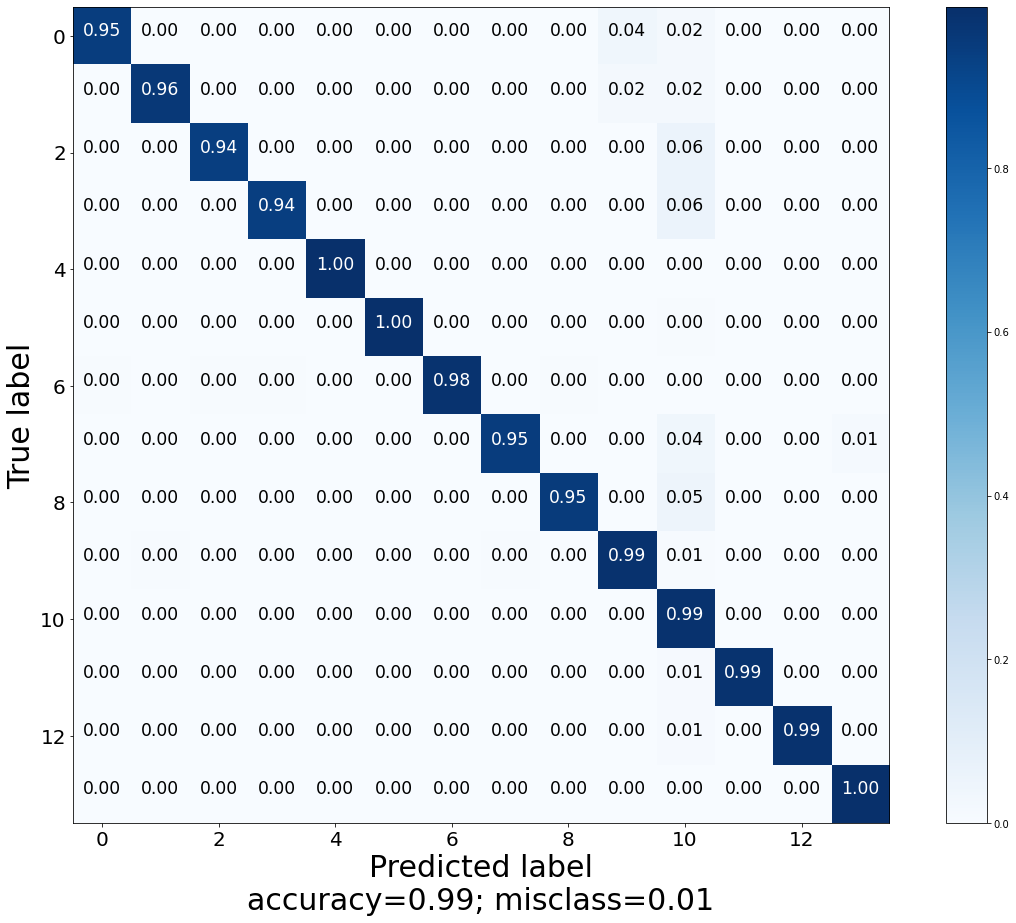

Done  60


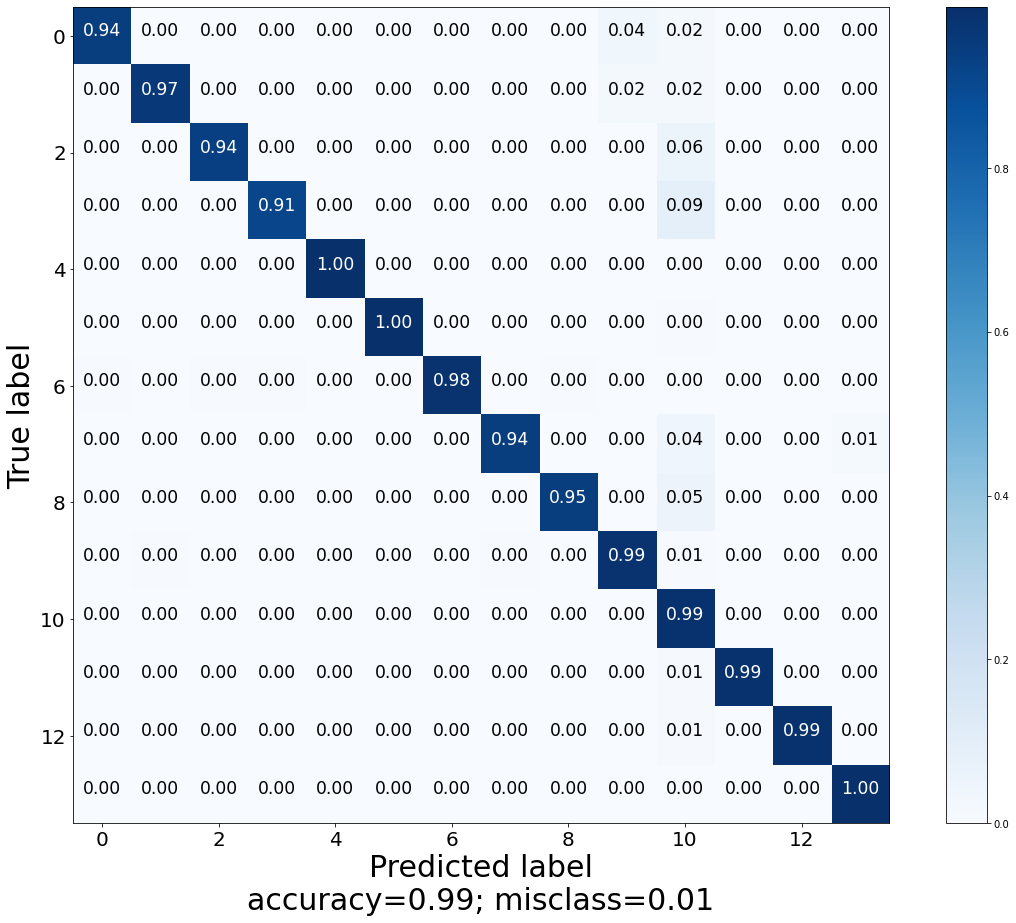

Done  61


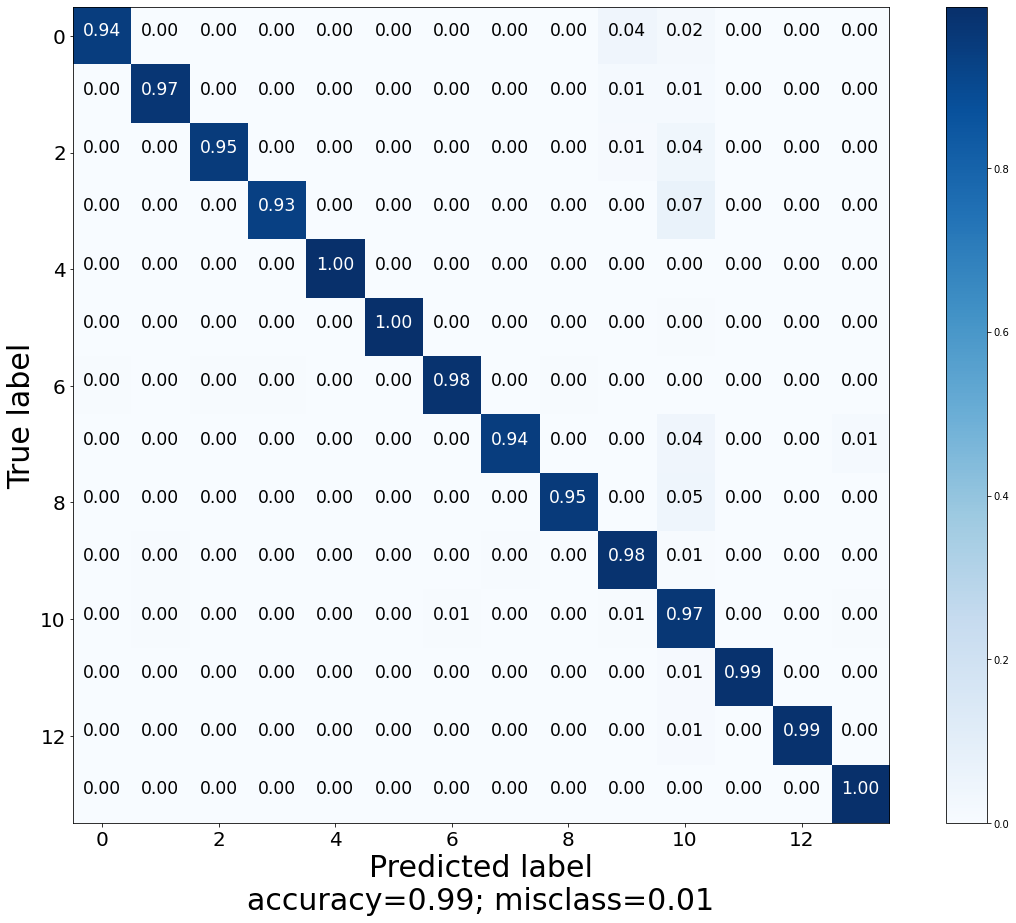

Done  62


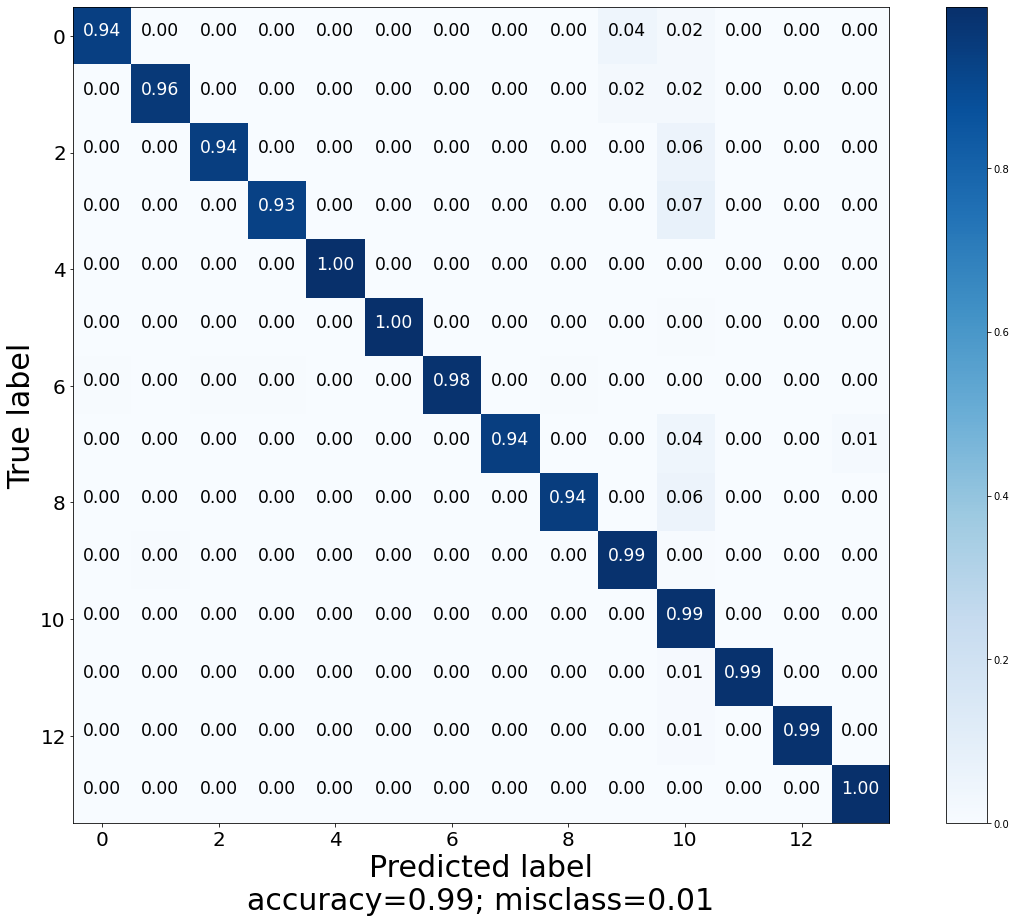

Done  63


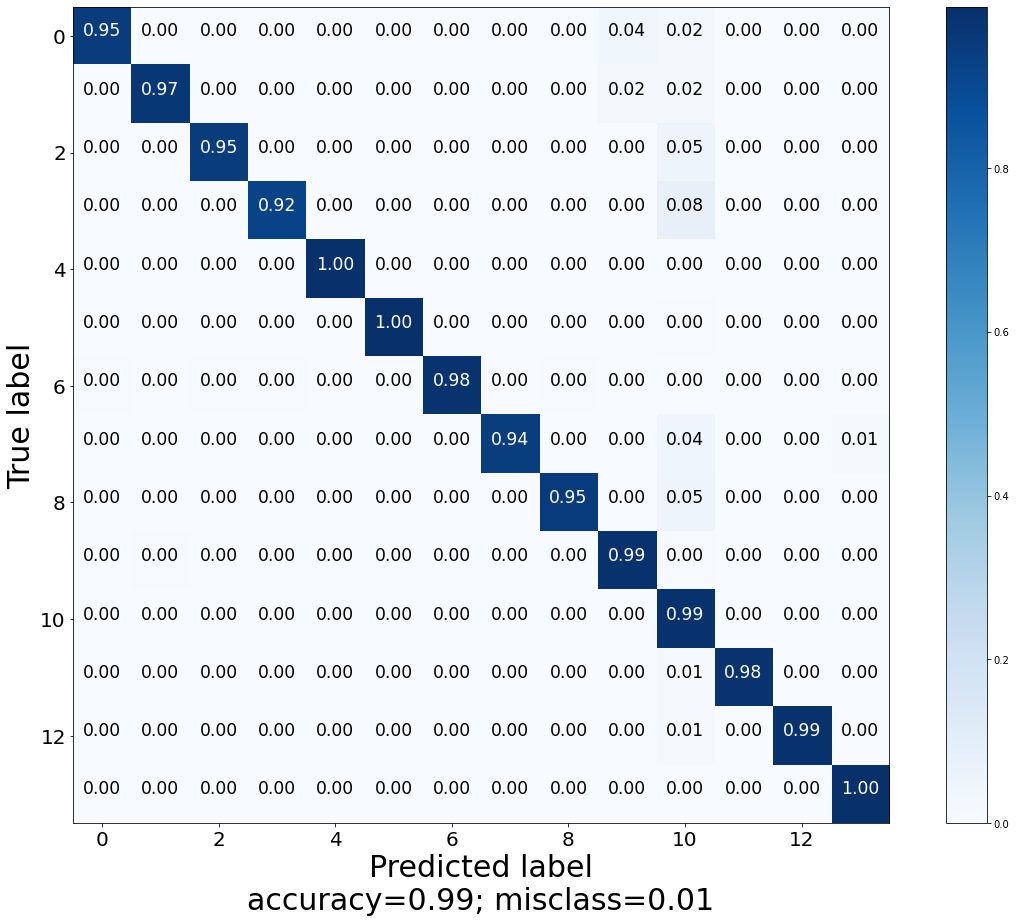

Done  64


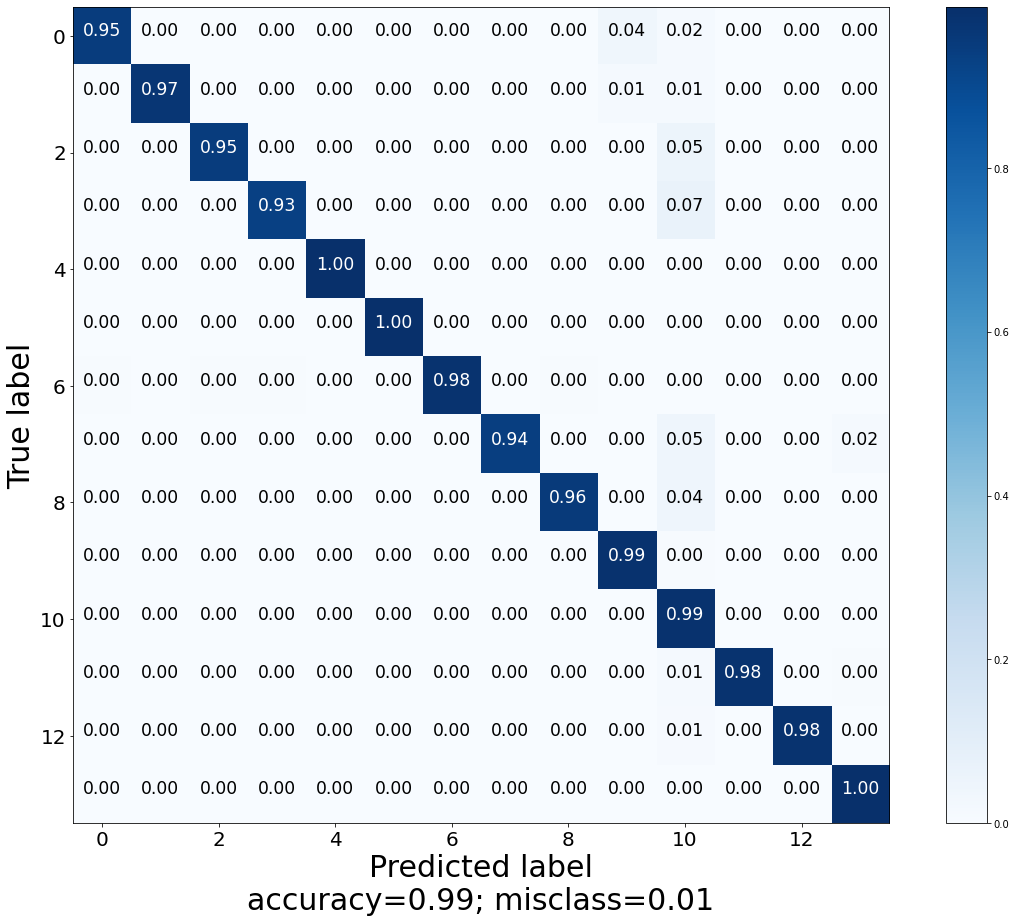

Done  65


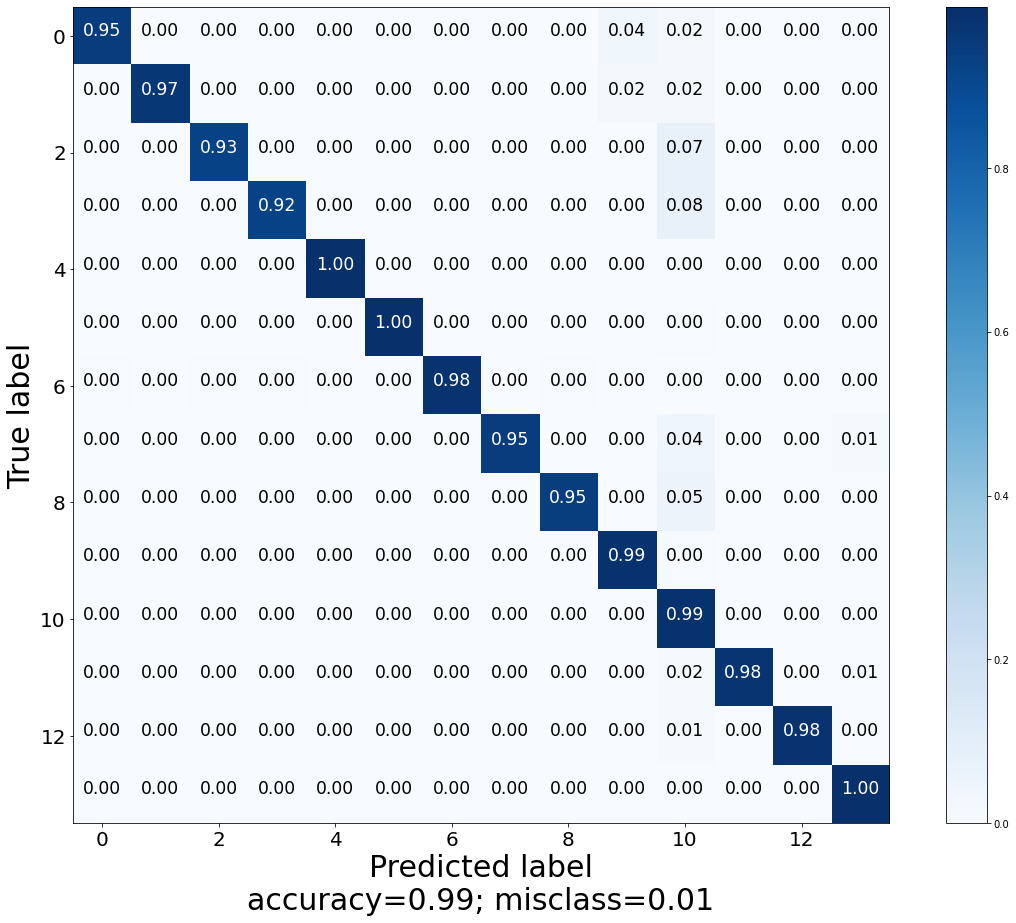

Done  66


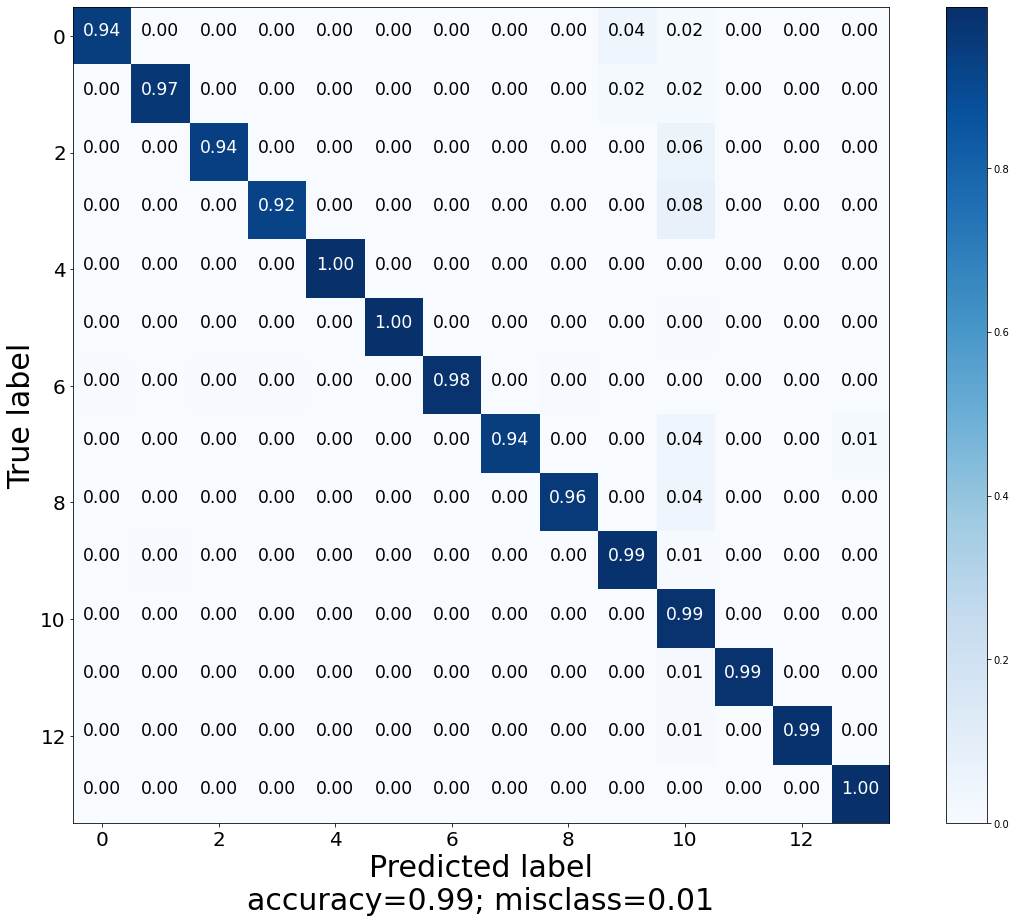

Done  67


In [48]:
test_per_list = p50_forecast['identifier'].unique()
save_dir = 'mobi_tft_wo_known_results/'
total_acc, total_precision, total_recall, total_f1 = 0., 0., 0., 0.

for num in test_per_list:
    forecast = p50_forecast[p50_forecast['identifier'] == num]
    target = targets[targets['identifier'] == num]

    forecast = forecast.drop(['forecast_time', 'identifier'], axis=1)
    target = target.drop(['forecast_time', 'identifier'], axis=1)
    
    acc, precision, recall, f1 = getScores(forecast, target)
    
    result = pd.DataFrame([acc, precision, recall, f1])
    result = result.T
    result.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    result.to_csv(save_dir + str(num) + 'result.csv')
    
    total_acc += acc
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    
    print('Done ', num)

In [49]:
print('Average Accuracy: ', total_acc / len(test_per_list))
print('Average Precision: ', total_precision / len(test_per_list))
print('Average Recall: ', total_recall / len(test_per_list))
print('Average F1 Score: ', total_f1 / len(test_per_list))

Average Accuracy:  0.9883473104810295
Average Precision:  0.9702593648710429
Average Recall:  0.9702724687890877
Average F1 Score:  0.9702659129780994


# Confusion matrix

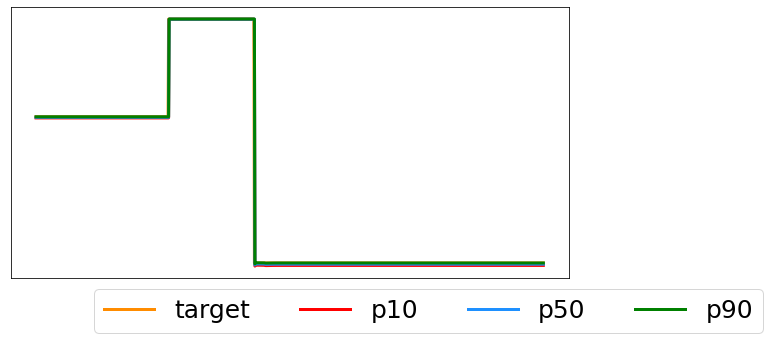

In [35]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5), facecolor='white')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.plot(output_map['targets']['t+0'][5500:6500], label='target', color='darkorange', linewidth=3)
plt.plot(output_map['p10']['t+0'][5500:6500], label='p10', color='red', linewidth=3)
plt.plot(output_map['p50']['t+0'][5500:6500], label='p50', color='dodgerblue', linewidth=3)
plt.plot(output_map['p90']['t+0'][5500:6500], label='p90', c='g', linewidth=3)
plt.legend(loc=(0.15, -0.2), ncol=4, fontsize=25)
plt.show()